# Point Net Homework

The following homework is based on the paper, "PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation" by Qi et al.

In this paper, the authors present a novel neural network architecture that takes in point clouds as inputs. This network can be used across many tasks including object segmentation, part segmentation, and scene semantic parsing. 

## 1. 3D Data Representation

There are various ways one could represent 3D before inputting into a neural network. Histocially, networks have used convolutional architecures, which require inputs to be highly standardized. As such, researchers will often convert their data into 3D voxel grids or collections of images. 

As stated by the authors, these data formats are volumous, due to data redundancy, and may introduce quantization artifacts. As such, we will be focusing on 3D Meshes and Point Clouds.



In [2]:
!pip install pyvista
!pip install numpy
!pip install pandas
!pip install torch
!pip install tqdm
!pip install trame

'\n!pip install pyvista\n!pip install numpy\n!pip install pandas\n!pip install torch\n!pip install tqdm\n'

In [3]:
import pyvista as pv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from dataset import ShapeNetDataset
from pytorch_model_summary import summary

### Prepare Data
for colab, please try:

`!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip`

`!unzip ModelNet10.zip -d ./datasets/`

In [ ]:
#@title Mount your Google Drive
import os
from google.colab import drive

try:
    drive.mount('/content/gdrive')

    DRIVE_PATH = '/content/gdrive/My\ Drive/cs182PN_sp23'
    DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
    if not os.path.exists(DRIVE_PYTHON_PATH):
    %mkdir $DRIVE_PATH

    ## the space in `My Drive` causes some issues,
    ## make a symlink to avoid this
    SYM_PATH = '/content/cs182PN'
    if os.path.isdir(SYM_PATH):
    raise Exception(f"Path already exists - please delete {SYM_PATH} before mounting again.")
    else:
    !ln -sf $DRIVE_PATH $SYM_PATH
except Exception as e:
    print(e)
    print("WARNING - Unable to mount google drive for storing logs. Storing logs in the runtime. Please keep downloading the logs to avoid losing data if the runtime terminates.")
    os.makedirs('/content/cs182PN/', exist_ok=True)

In [ ]:
%cd $SYM_PATH
if not os.path.exists("cs182-proj"):
    !git clone https://github.com/leonardwei2023/cs182-proj.git
%cd cs182-proj

In [ ]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
!unzip ModelNet10.zip -d ./datasets/

In [2]:
teapot_file_path = '../cs182-proj/images/canvas3D-master/teapot.ply'
points_data = pv.read(teapot_file_path)

### 3D Mesh

The 3D Mesh is generated using a set of polygons to represent the structure of the object. It is determined using points with X, Y, Z coordinates. These points are connected to make polygons, most commonly triangles and quads.


D:\Users\ALIENWARE\Anaconda3\envs\torch190\lib\site-packages\pyvista\jupyter\notebook.py:59: UserWarning: Failed to use notebook backend: 

Install ``panel`` to use this feature

Falling back to a static output.
  f'Failed to use notebook backend: \n\n{e}\n\nFalling back to a static output.'


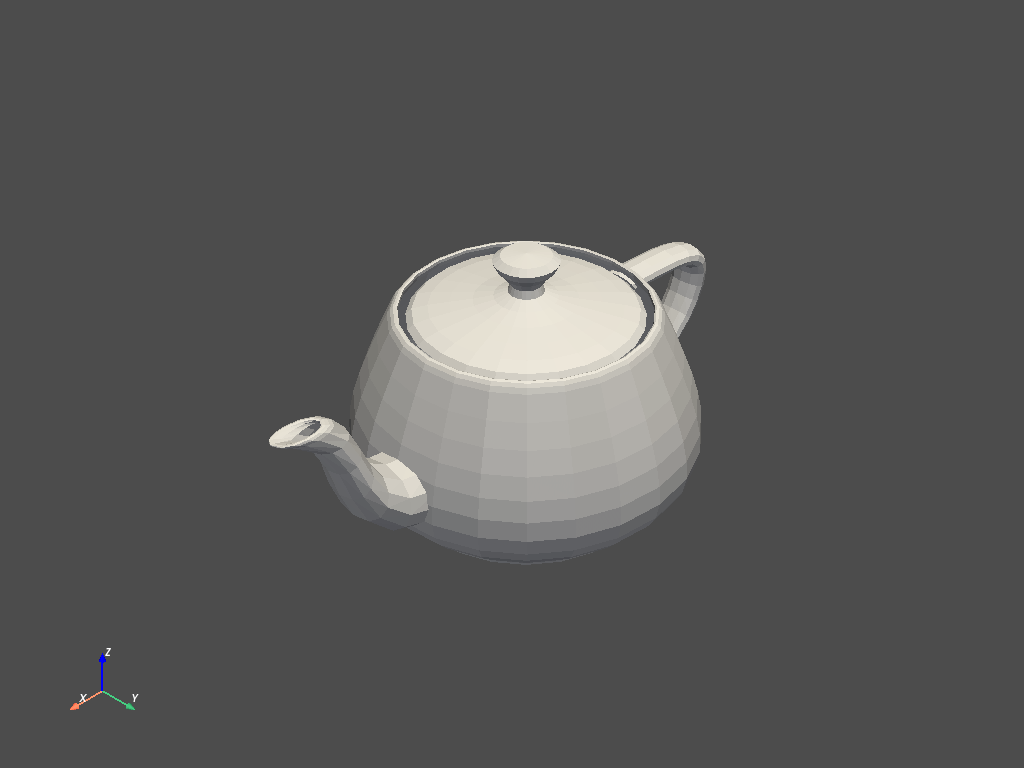

In [3]:
points_data.plot(jupyter_backend='panel')

### Point Cloud
Point Clouds are a basic data format in which the points are represented in 3D space, using X, Y, and Z coordinates. 

D:\Users\ALIENWARE\Anaconda3\envs\torch190\lib\site-packages\pyvista\jupyter\notebook.py:59: UserWarning: Failed to use notebook backend: 

Install ``panel`` to use this feature

Falling back to a static output.
  f'Failed to use notebook backend: \n\n{e}\n\nFalling back to a static output.'


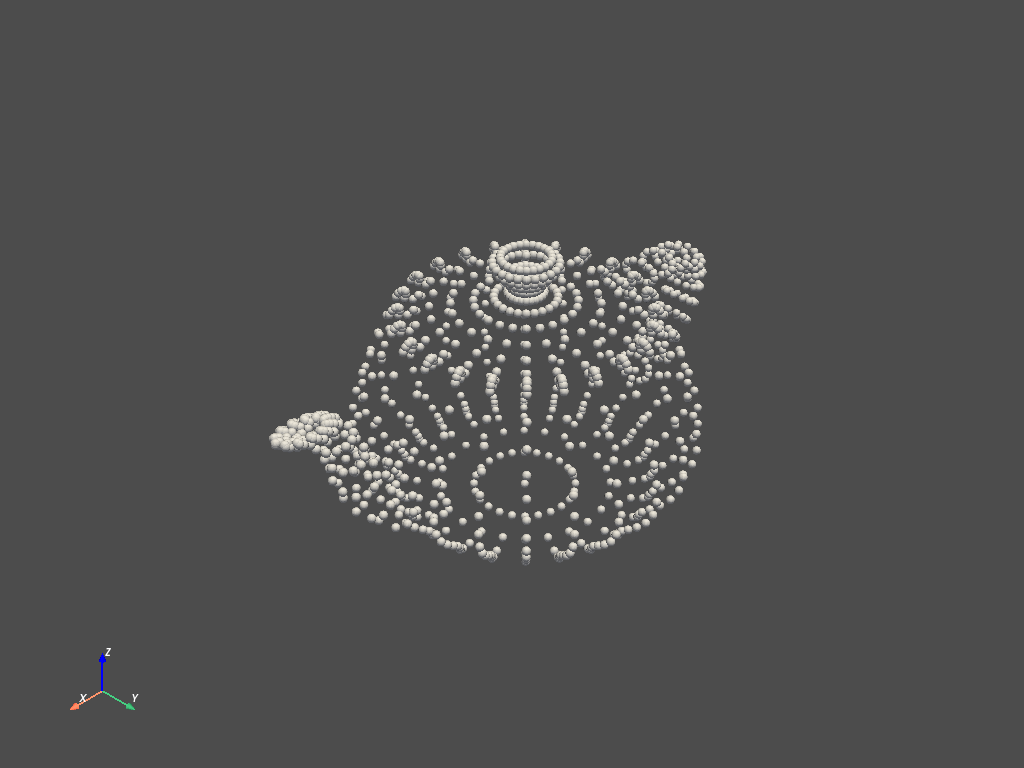

In [4]:
sphere = pv.Sphere(radius=0.05)
pc = points_data.glyph(scale=False, geom=sphere, orient=False)
pc.plot(cmap='Reds', jupyter_backend='panel')

The authors in the paper chose to use Point Clouds instead of a 3D Mesh. **Looking at the objects, why would they choose to do so?**

Solution: 3D Meshes have additional complexity and combinations that must be carried through, thereby drastically increasing the complexity of the data format. Further, there is likely little value add by including this additional information outside of for visualization purposes.

## 2. The Model Architecture

The archicture of PointNet is as follows:
![plot](images/model.png)

In the paper, the authors used the ModelNet10 dataset and the ModelNet40 dataset. The ModelNet10 dataset has 10 classes of varying objects.

![plot](images/class_detail.png)

However, given the size of the dataset, it is not feasible to train the entire model in the context of this homework. As such, we have modified the dataset to be a binary classification problem: bathtub or table.

In the following sections we will implement pieces of the architecture and see how they impact the downstream performance of the model

In [7]:
n = 10000
num_classes = 2
epochs = 5

trainset = ShapeNetDataset("datasets/ModelNet10", train=True, n=n)
testset = ShapeNetDataset("datasets/ModelNet10", train=False, n=n)

dataset_length = len(trainset)
train_ratio = 0.7
test_ratio = 0.3

train_len = int(dataset_length * train_ratio)
valid_len = dataset_length - train_len

trainset, validset = random_split(trainset, [train_len, valid_len])


In [8]:
def loss_fn(preds, labels, feature_transform, reg=0.0001):
    loss = torch.nn.NLLLoss()
    def feat_loss(A):
        I = torch.eye(64, requires_grad=True).expand(A.size(0), -1, -1)
        AA_T = torch.bmm(A, A.transpose(1, 2))
        return torch.linalg.norm(I - AA_T, ord='fro', dim=(1,2))
    return loss(preds, labels) + reg * torch.mean(feat_loss(feature_transform))

def train(model, trainset, validset, optimizer, epochs=10, batch_size=32, device=torch.device('cpu')):
    train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(validset, batch_size=batch_size, shuffle=True)

    train_losses, train_accs = [], []
    valid_losses, valid_accs = [], []

    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()
        # Train and get training loss and accuracy
        train_loss, train_num_correct = [], []
        for x, y in tqdm(train_dataloader, unit='batch'):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred, feat = model(x)
            loss = loss_fn(pred, y, feat)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_num_correct.append(torch.sum(pred.argmax(1) == y).item())
        train_losses.append(np.mean(train_loss))
        train_accs.append(np.sum(train_num_correct) / len(trainset))

        model.eval()
        # Get validation loss and accuracy
        with torch.no_grad():
            valid_loss, valid_num_correct = [], []
            for x, y in tqdm(valid_dataloader, unit='batch'):
                x, y = x.to(device), y.to(device)
                pred, feat = model(x)
                loss = loss_fn(pred, y, feat)
                valid_loss.append(loss.item())
                valid_num_correct.append(torch.sum(pred.argmax(1) == y).item())
        valid_losses.append(np.mean(valid_loss))
        valid_accs.append(np.sum(valid_num_correct) / len(validset))
        
        #print('Finished Epoch {}\n training loss: {}, validation loss: {} \n training accuracy: {}, validation accuracy: {}'
        #        .format(epoch+1, train_losses[-1], valid_losses[-1], train_accs[-1], valid_accs[-1]))

    return train_losses, valid_losses, train_accs, valid_accs

In [9]:
def plot_charts(train_accs, train_losses, valid_accs, valid_losses):
    
    fig, axs = plt.subplots(2, figsize=(10, 8))
    
    axs[0].plot(train_accs, label='train')
    axs[0].plot(valid_accs, label='valid')
    axs[0].set_title('Accuracy')
    axs[0].set_xlabel('Epochs')
    
    axs[1].plot(train_losses, label='train')
    axs[1].plot(valid_losses, label='valid')
    axs[1].set_title('Loss')
    axs[1].set_xlabel('Epochs')
    
    plt.tight_layout()
    plt.legend()
    plt.show()
    

### 2.1 Baseline Architecture

The first draft of the model will exclude the input transform and the feature transform.

In the following section, please implement the following:
- Complete the SharedMLP Class: This will include adding the appropriate number of layers, a BatchNorm, and ReLU activation function
- Complete the forward function for the BaselineClassificationNN




In [10]:
class MLP(nn.Sequential):
    def __init__(self, layer_sizes, dropout=0.7):
        layers = []
        for i in range(len(layer_sizes)-1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nn.BatchNorm1d(layer_sizes[i+1]))
            layers.append(nn.Dropout(dropout))
            layers.append(nn.ReLU())
        super(MLP, self).__init__(*layers)
            

class SharedMLP(nn.Sequential):
    def __init__(self, layer_sizes):
        layers = []
        for i in range(len(layer_sizes)-1):
            layers.append(nn.Conv1d(layer_sizes[i], layer_sizes[i+1], 1))
            layers.append(nn.BatchNorm1d(layer_sizes[i+1]))
            layers.append(nn.ReLU())
        super(SharedMLP, self).__init__(*layers)

In [11]:
class BaselineClassificationNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineClassificationNN, self).__init__()
        
        self.shared_mlp_1 = SharedMLP([3, 64, 64])
        self.shared_mlp_2 = SharedMLP([64, 64, 128, 1024])
        self.mlp = MLP([1024, 512, 256, num_classes])

    def forward(self, x):

        feat_out = self.shared_mlp_1(x)
        out = self.shared_mlp_2(feat_out)
        out = F.max_pool1d(out, x.size(-1)).view(x.size(0), -1)
        out = self.mlp(out)
        return out, feat_out

    def predict(self, x):
        return self.forward(x)[0]

In [11]:
baseline_model = BaselineClassificationNN(num_classes)
lr = 0.0001
device = 'cpu'

optimizer = torch.optim.Adam(baseline_model.parameters(), lr=lr)
baseline_train_losses, baseline_valid_losses, baseline_train_accs, baseline_valid_accs = train(baseline_model, trainset, validset, optimizer, epochs=epochs, device=device)

  0%|          | 0/88 [00:00<?, ?batch/s]

D:\Users\ALIENWARE\Anaconda3\envs\torch190\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1260.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


IndexError: Target 5 is out of bounds.

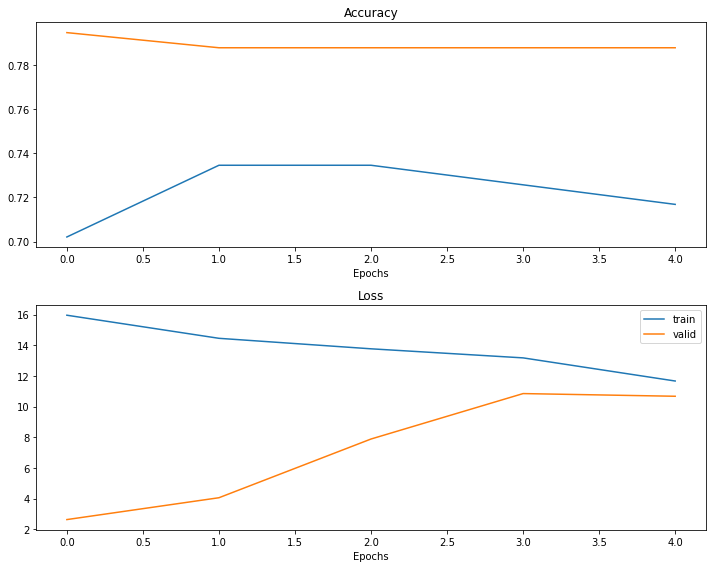

In [11]:
plot_charts(baseline_train_accs, baseline_train_losses, baseline_valid_accs, baseline_valid_losses)

### 2.2 Add Input Transform

In the following section, please implement the following:
- Complete the TNet Class: This will include adding the appropriate number of layers, a BatchNorm, and ReLU activation function
- Modify the BaselineClassificationNN to include the Input Transform

In [14]:
class T_net(nn.Module):
    def __init__(self, size, dropout=0.7, bn_momentum=None):
        super(T_net, self).__init__()
        self.size = size

        self.shared_mlp = SharedMLP([size, 64, 128, 1024])

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, size*size, bias=False)
        self.fc3.requires_grad_(False)

        self.bn1 = nn.BatchNorm1d(512, momentum=bn_momentum)
        self.bn2 = nn.BatchNorm1d(256, momentum=bn_momentum)

    def forward(self, x):
        '''
            Input: B x size x N
        '''
        out = self.shared_mlp(x)
        out = F.max_pool1d(out, kernel_size=x.size(-1))
        out = out.view(-1, 1024)
        out = F.relu(self.bn1(self.fc1(out)))
        out = F.relu(self.bn2(self.fc2(out)))

        out = self.fc3(out)
        out = out.view(-1, self.size, self.size)
        bias = torch.eye(self.size, requires_grad=True).expand(x.size(0), -1, -1)
        return out + bias


In [15]:
class InputTransform(nn.Module):
    def __init__(self):
        super(InputTransform, self).__init__()
        self.T_net = T_net(3)

    def forward(self, x):
        out = self.T_net(x)
        return torch.bmm(x.transpose(1, 2), out).transpose(1, 2)

In [16]:
class InputTransformClassificationNN(nn.Module):
    def __init__(self, num_classes):
        super(InputTransformClassificationNN, self).__init__()
        self.input_transform = InputTransform()
        self.shared_mlp_1 = SharedMLP([3, 64, 64])
        self.shared_mlp_2 = SharedMLP([64, 64, 128, 1024])
        self.mlp = MLP([1024, 512, 256, num_classes])

    def forward(self, x):

        out = self.input_transform(x)
        feat_out = self.shared_mlp_1(out)
        out = self.shared_mlp_2(feat_out)
        out = F.max_pool1d(out, x.size(-1)).view(x.size(0), -1)
        out = self.mlp(out)
        return out, feat_out

    def predict(self, x):
        return self.forward(x)[0]

In [15]:
input_transform_model = InputTransformClassificationNN(num_classes)
lr = 0.0001
device = 'cpu'

optimizer = torch.optim.Adam(input_transform_model.parameters(), lr=lr)
input_train_losses, input_valid_losses, input_train_accs, input_valid_accs = train(input_transform_model, trainset, validset, optimizer, epochs=epochs, device=device)

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

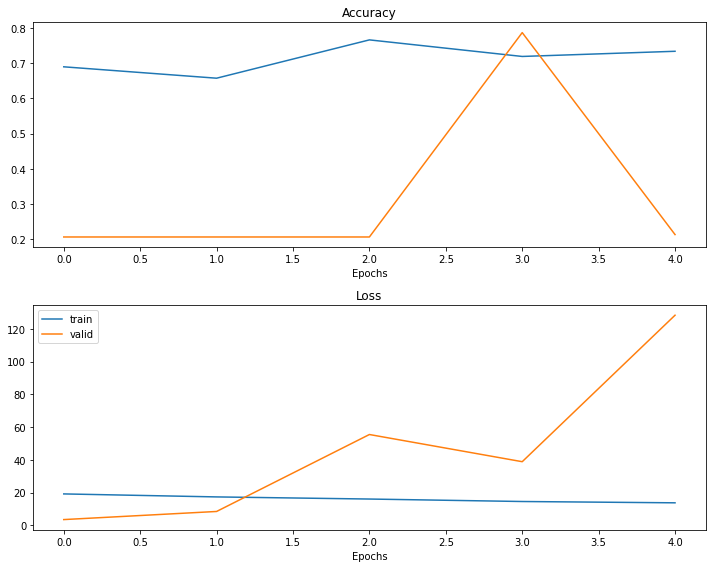

In [20]:
plot_charts(input_train_accs, input_train_losses, input_valid_accs, input_valid_losses)

### 2.2 Add Feature Transform

In the following section, please implement the following:
- Complete the FeatureTransform Class
- Update the FeatureTransformClassificationNN to include the Feature Transform

In [12]:
class FeatureTransform(nn.Module):
    def __init__(self):
        super(FeatureTransform, self).__init__()
        self.T_net = T_net(64)

    def forward(self, x):
        out = self.T_net(x)
        self.A = out
        return torch.bmm(x.transpose(1, 2), out).transpose(1, 2)

In [13]:
class FullClassificationNN(nn.Module):
    def __init__(self, num_classes):
        super(FullClassificationNN, self).__init__()
        self.input_transform = InputTransform()
        self.feature_transform = FeatureTransform()
        self.shared_mlp_1 = SharedMLP([3, 64, 64])
        self.shared_mlp_2 = SharedMLP([64, 64, 128, 1024])
        self.mlp = MLP([1024, 512, 256, num_classes])

    def forward(self, x):
        out = self.input_transform(x)
        out = self.shared_mlp_1(out)
        feat_out = self.feature_transform(out)
        out = self.shared_mlp_2(feat_out)
        out = F.max_pool1d(out, x.size(-1)).view(x.size(0), -1)
        out = self.mlp(out)
        return out, feat_out

    def predict(self, x):
        return self.forward(x)[0]

In [18]:
full_model = FullClassificationNN(num_classes)
lr = 0.0001
device = 'cpu'

optimizer = torch.optim.Adam(full_model.parameters(), lr=lr)
full_train_losses, full_valid_losses, full_train_accs, full_valid_accs = train(full_model, trainset, validset, optimizer, epochs=epochs, device=device)

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

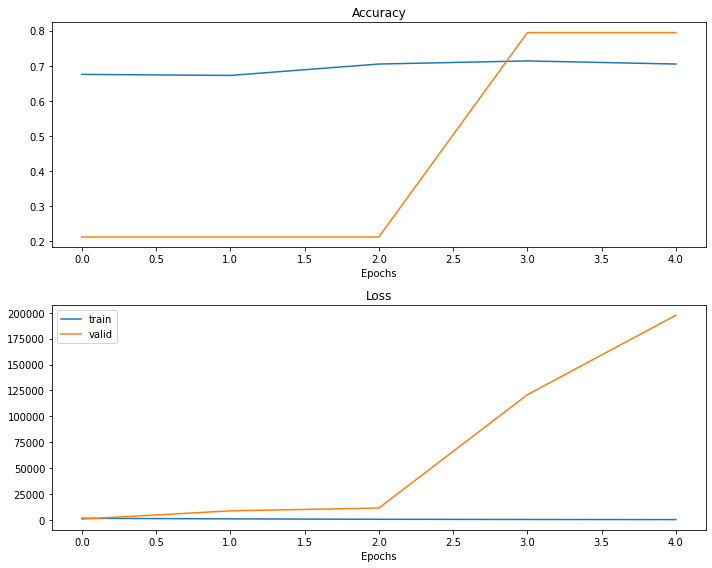

In [21]:
plot_charts(full_train_accs, full_train_losses, full_valid_accs, full_valid_losses)

# Segmentation

###### ![plot](images/model.png)

In [20]:
class SegmentationNN(nn.Module):
    def __init__(self, num_features: int):
        super(SegmentationNN, self).__init__()
        self.input_transform = InputTransform()
        self.feature_transform = FeatureTransform()

        self.mlp_1 = SharedMLP([3, 64, 64])
        self.mlp_2 = SharedMLP([64, 64, 128, 1024])
        ####################################
        # Complete the PointNet for Semantic Segmentation.
        # Hint: a. You can use the SharedMLP Structure that we've already implemented above
        # 1. self.mlp_3 = SharedMLP([?, ?, ?, ?])
        # 2. self.mlp_4 = SharedMLP([?, ?, ?])
        # Hint: b. Think about the yellow part in the above diagram.
        ####################################
        self.mlp_3 = SharedMLP([1088, 512, 256, 128])
        self.mlp_4 = SharedMLP([128, 128, num_features])
        ####################################
        # End of Your Code
        ####################################
        
    def forward(self, x):
        out = self.input_transform(x)
        out = self.mlp_1(out)
        feat_out = self.feature_transform(out)
        global_feature = self.mlp_2(out)
        ####################################
        # Implement the forward function
        # Hint: you need to flatten the global features
        # and then concat it with the transformed feature.
        # You may find F.max_pool1d useful for this task.
        ####################################
        global_feature = F.max_pool1d(global_feature, x.size(2))
        global_feature = global_feature.expand(-1, -1, x.size(-1))
        out = torch.cat([out, global_feature], 1)
        ####################################
        # End of Your Code
        ####################################
        out = self.mlp_3(out)
        out = self.mlp_4(out)
        return out, feat_out

    def predict(self, x):
        return self.forward(x)[0]

#### Test

In [19]:
from pytorch_model_summary import summary
rand_data = Variable(torch.rand(32, 3, 100)) # B X 3 X N
seg_net = SegmentationNN(num_features=10)
out = seg_net(rand_data)
print(summary(seg_net, rand_data))
assert out[0].size()==(32,10,100)
assert out[1].size()==(32,64,100)
print('pass')

--------------------------------------------------------------------------
         Layer (type)        Output Shape         Param #     Tr. Param #
     InputTransform-1        [32, 3, 100]         803,072         800,768
             Conv1d-2       [32, 64, 100]             256             256
        BatchNorm1d-3       [32, 64, 100]             128             128
               ReLU-4       [32, 64, 100]               0               0
             Conv1d-5       [32, 64, 100]           4,160           4,160
        BatchNorm1d-6       [32, 64, 100]             128             128
               ReLU-7       [32, 64, 100]               0               0
   FeatureTransform-8       [32, 64, 100]       1,853,248         804,672
             Conv1d-9       [32, 64, 100]           4,160           4,160
       BatchNorm1d-10       [32, 64, 100]             128             128
              ReLU-11       [32, 64, 100]               0               0
            Conv1d-12      [32, 128, 

#### Questions:
- what's the number of trainable params of our model with num_features = 10?

# Load Pretrained Model
Since the data which is used to train semantic segmentation model is around 13GB, and might take you about 1.5 hour to download it from http://buildingparser.stanford.edu/dataset.html. 
So here we directly show the result of a pretrained model from the following repo: https://github.com/yanx27/Pointnet_Pointnet2_pytorch/blob/master/log/sem_seg/pointnet_sem_seg/checkpoints/best_model.pth

In [1]:
import sys
sys.path
sys.path.append('./pretrained')
from test_semseg import main as pretrained_sem
%load_ext autoreload
%autoreload 2

In [2]:
pretrained_sem({"log_dir":'pointnet_sem_seg',
                "test_area":5,
                "visual":True,
                "gpu":'0',
                "batch_size":32,
                "num_point": 4096,
                "test_area": 5,
                "num_votes": 3
               })

PARAMETER ...
{'log_dir': 'pointnet_sem_seg', 'test_area': 5, 'visual': True, 'gpu': '0', 'batch_size': 32, 'num_point': 4096, 'num_votes': 3}
The number of test data is: 1


./pretrained\data_utils\S3DISDataLoader.py:119: RuntimeWarning: divide by zero encountered in true_divide
  self.labelweights = np.power(np.amax(labelweights) / labelweights, 1 / 3.0)


---------------------------------------------------------------------------------------------------
        Layer (type)                                  Output Shape         Param #     Tr. Param #
   PointNetEncoder-1     [32, 1088, 100], [32, 3, 3], [32, 64, 64]       2,804,297       2,804,297
            Conv1d-2                                [32, 512, 100]         557,568         557,568
       BatchNorm1d-3                                [32, 512, 100]           1,024           1,024
            Conv1d-4                                [32, 256, 100]         131,328         131,328
       BatchNorm1d-5                                [32, 256, 100]             512             512
            Conv1d-6                                [32, 128, 100]          32,896          32,896
       BatchNorm1d-7                                [32, 128, 100]             256             256
            Conv1d-8                                 [32, 13, 100]           1,677           1,677
Total par

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.74s/it]


[0.10915768 0.9663703  0.60805182 0.         0.         0.
 0.15533345 0.         0.         0.         0.         0.
 0.29059017]
Mean IoU of Area_5_storage_3: 0.4259
----------------------------
------- IoU --------
class ceiling       , IoU: 0.109 
class floor         , IoU: 0.966 
class wall          , IoU: 0.608 
class beam          , IoU: 0.000 
class column        , IoU: 0.000 
class window        , IoU: nan 
class door          , IoU: 0.155 
class table         , IoU: 0.000 
class chair         , IoU: 0.000 
class sofa          , IoU: nan 
class bookcase      , IoU: 0.000 
class board         , IoU: 0.000 
class clutter       , IoU: 0.291 

eval point avg class IoU: 0.163808
eval whole scene point avg class acc: 0.194869
eval whole scene point accuracy: 0.613571
Done!


./pretrained\test_semseg.py:194: RuntimeWarning: invalid value encountered in true_divide
  total_correct_class[l] / float(total_iou_deno_class[l]))


# Visualize the Segmented Scene

D:\Users\ALIENWARE\Anaconda3\envs\torch190\lib\site-packages\pyvista\jupyter\notebook.py:59: UserWarning: Failed to use notebook backend: 

Please install `nest_asyncio` to automagically launch the trame server without await. Or, to avoid `nest_asynctio` run:

    from pyvista.trame.jupyter import launch_server
    await launch_server().ready


Falling back to a static output.
  f'Failed to use notebook backend: \n\n{e}\n\nFalling back to a static output.'


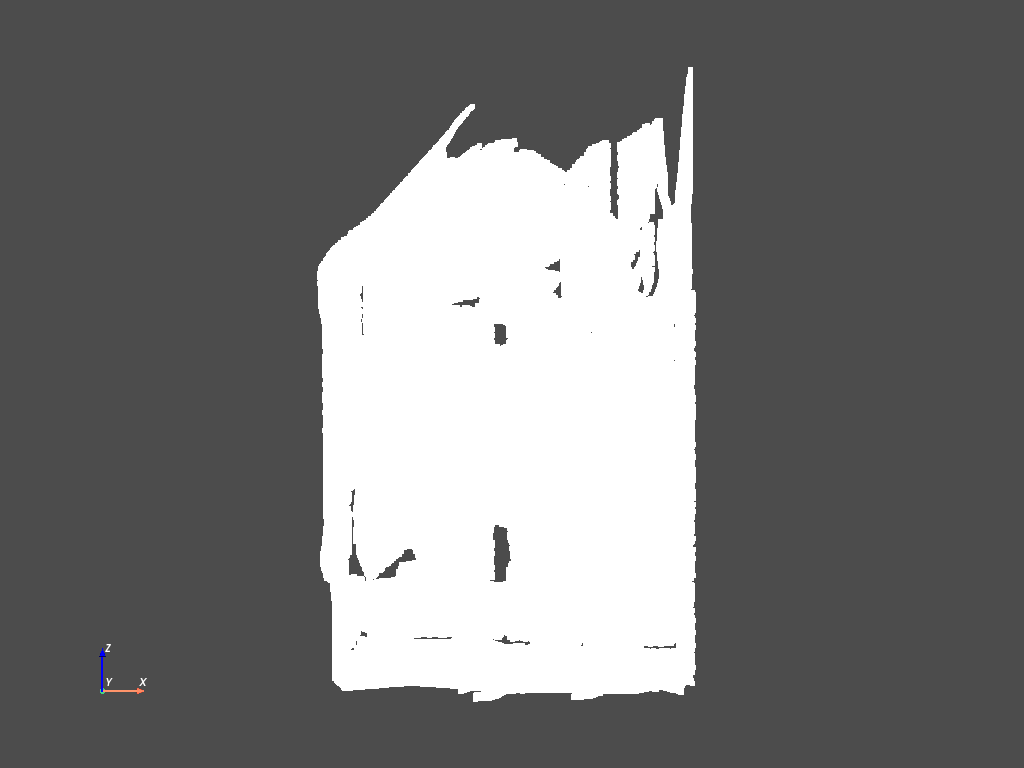

In [3]:
import pyvista
from pyvista import examples
mesh = pyvista.read('./pretrained\\log\\sem_seg\\pointnet_sem_seg\\visual\\Area_5_storage_3_pred.obj')
mesh.plot(cpos='xz')

If the color is not properly displayed, you can also open the obj file with pandas 

In [4]:
import pandas as pd
df = pd.read_csv('./pretrained\\log\\sem_seg\\pointnet_sem_seg\\visual\\Area_5_storage_3_pred.obj', 
                   sep=" ", header=None, names=['v','x','y','z','R','G','B']).drop(columns=['v'])
df.describe()

,x,y,z,R,G,B
count,175538.000000,175538.000000,175538.000000,175538.000000,175538.000000,175538.000000
mean,0.870121,0.968066,1.326805,40.017575,192.568504,198.821594
std,0.657654,0.568673,0.939198,82.936191,100.505684,94.637849
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.264000,0.399000,0.461000,0.000000,200.000000,100.000000
50%,0.780000,0.981000,1.316000,0.000000,255.000000,255.000000
75%,1.457000,1.509000,2.169000,10.000000,255.000000,255.000000
max,1.964000,1.752000,3.256000,255.000000,255.000000,255.000000


In [5]:
# Create the PointSet from the DataFrame
point_set = pyvista.PolyData(df[['x', 'y', 'z']].values)
point_set.point_data['rgb'] = df[['R', 'G', 'B']].values

In [6]:
!pip install matplotlib==3.5.0

^C


D:\Users\ALIENWARE\Anaconda3\envs\torch190\lib\site-packages\pyvista\jupyter\notebook.py:59: UserWarning: Failed to use notebook backend: 

Please install `nest_asyncio` to automagically launch the trame server without await. Or, to avoid `nest_asynctio` run:

    from pyvista.trame.jupyter import launch_server
    await launch_server().ready


Falling back to a static output.
  f'Failed to use notebook backend: \n\n{e}\n\nFalling back to a static output.'


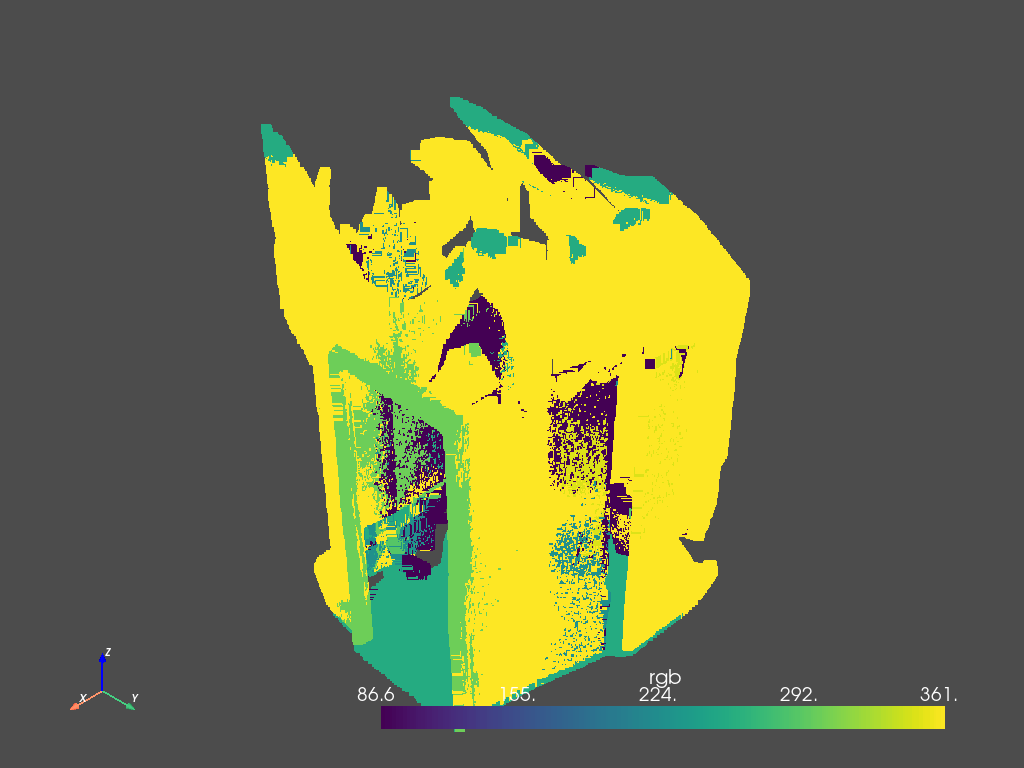

In [7]:
point_set.plot(point_size=10)